In [2]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from skimage.feature import canny
from collections import defaultdict
from PIL import Image
from skimage.color import rgba2rgb, rgb2gray
from skimage.feature import local_binary_pattern
from itertools import combinations
from shapely.geometry import box
from shapely.geometry.polygon import Polygon

matplotlib.rcParams['font.family'] = 'Times New Roman'

In [3]:
file_path = "./merged_file.json"

with open(file_path, 'r') as file:
    json_data = file.read()

## Cantidad de fotos por set

In [4]:
directorio = './images'

In [5]:
cantidad_fotos = 0

# Recorrer todas las imágenes en el directorio
for filename in os.listdir(directorio):
    if filename.endswith('.png'):
        cantidad_fotos += 1

# Imprimir la cantidad total de fotos
print(f"La carpeta '{directorio}' contiene {cantidad_fotos} fotos.")

La carpeta './images' contiene 2000 fotos.


In [6]:
fotos_por_set = defaultdict(int)

for filename in os.listdir(directorio):
    if filename.endswith('.png'):
        numero_set = filename.split('_')[0]
        fotos_por_set[numero_set] += 1

# print("Frecuencia de fotos por set:")
# for numero_set, cantidad in fotos_por_set.items():
#     print(f"Set {numero_set}: {cantidad} fotos")

In [7]:
df = pd.read_csv('layoutsWithTags.csv')
numeros_de_sets_csv = df['layout_id'].unique()

def verificar_coincidencia(numero_set_csv):
    return str(numero_set_csv) in fotos_por_set

df['coincidencia'] = df['layout_id'].apply(verificar_coincidencia)
df_coincidentes = df[df['coincidencia']]

df_coincidentes.to_csv('layoutsWithTags.csv', index=False)

print(f"Se han guardado {len(df_coincidentes)} casos coincidentes en 'layoutsWithTags_coincidentes.csv'.")

Se han guardado 113 casos coincidentes en 'layoutsWithTags_coincidentes.csv'.


C:\Users\nicky\AppData\Local\Temp\ipykernel_11452\3919347955.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


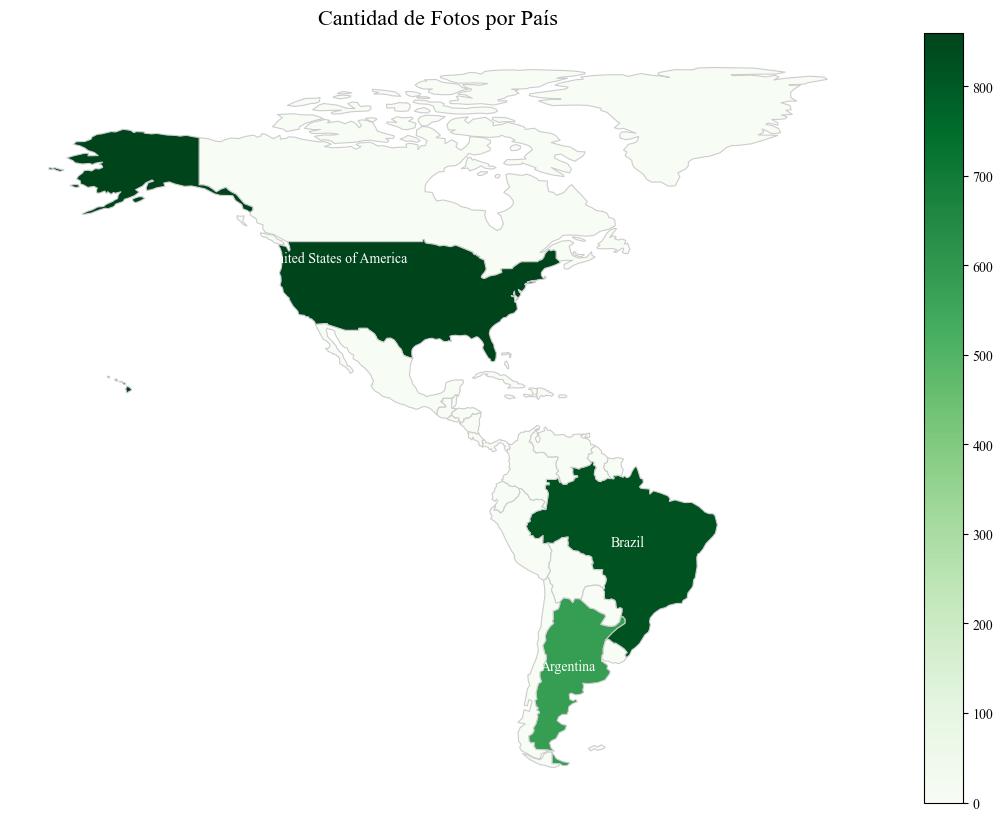

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Leer el dataset
df = pd.read_csv('layoutsWithTags.csv')

# Modificar Estados Unidos a United States of America
df['country'] = df['country'].replace({'USA': 'United States of America'})

# Calcular el conteo de fotos por país
conteo_paises = df['country'].value_counts() * 20  # Multiplicar por 20

# Cargar el archivo de datos geoespaciales del mundo
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filtrar solo los países de América
world_americas = world[(world['continent'] == 'North America') | (world['continent'] == 'South America')]

# Unir el conteo de fotos por país con los datos geoespaciales
world_americas = world_americas.merge(conteo_paises, how='left', left_on='name', right_index=True)

# Tratar los países sin datos como cero fotos
world_americas[conteo_paises.name] = world_americas[conteo_paises.name].fillna(0)

# Configurar el estilo del mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Graficar el mapa con un esquema de color verde
world_americas.plot(column=conteo_paises.name, cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Agregar etiquetas solo en los países con datos
for idx, row in world_americas.iterrows():
    if row[conteo_paises.name] > 0:
        plt.annotate(text=row['name'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y), 
                     horizontalalignment='center', verticalalignment='center', fontsize=10, color='white', fontname='Times New Roman')

# Agregar título
plt.title('Cantidad de Fotos por País', fontsize=16)

# Mostrar el mapa
plt.axis('off')
plt.show()


## Etiquetas

In [9]:
sin_etiquetas = df['relevant (new) tags'].isnull().sum()
fotos_sin_etiquetas = sin_etiquetas * 20

print(f"Total de filas sin etiquetas: {sin_etiquetas}")
print(f"Total de fotos sin etiquetas: {fotos_sin_etiquetas}")

Total de filas sin etiquetas: 13
Total de fotos sin etiquetas: 260


# Análisis grupos tamaño 
### Este código tardad bastante (3min) en correr

In [26]:
import os
from PIL import Image, ImageStat
import pandas as pd

# Lista para almacenar las filas de datos
filas = []

# Iterar sobre cada fila del DataFrame original
for index, row in df.iterrows():
    layout_id = row['layout_id']
    country = row['country']
    relevant = row['relevant (new) tags']
    coincidencia = row['coincidencia']
    # Buscar imágenes correspondientes a ese layout en el directorio
    for filename in os.listdir(directorio):
        if filename.startswith(str(layout_id) + '_'):  # Verificar si el nombre de la imagen contiene el layout ID
            # Leer la imagen y extraer características
            img = Image.open(os.path.join(directorio, filename))
            ancho, largo = img.size
            brillo = img.getextrema()[0][0]
            tonalidad = img.getextrema()[1][0]

            # Calcular la saturación
            s, _, _ = img.convert('HSV').split()
            estadisticas_saturacion = ImageStat.Stat(s)
            saturacion = estadisticas_saturacion.mean[0]

            # Agregar los datos de la fila a la lista
            filas.append({
                'trial_id': row['trial_id'],
                'layout_id': layout_id,
                'country': country,
                'relevant (new) tags': relevant,
                'coincidencia': coincidencia,
                'nombre_imagen': filename,
                'ancho': ancho,
                'largo': largo,
                'brillo': brillo,
                'tonalidad': tonalidad,
                'saturacion': saturacion,
            })

# Convertir la lista de diccionarios en un DataFrame
nuevo_df = pd.concat([nuevo_df, pd.DataFrame(filas)], ignore_index=True)

# Guardar el nuevo DataFrame en un archivo CSV

nuevo_df.to_csv(r'C:\Users\nicky\OneDrive\Itba\nuevo.csv', index=False)


OSError: Cannot save file into a non-existent directory: 'H:\My Drive44 1C\Repositorio GitHub Vacas Vaqueras\PF-vacasVaqueras'

In [31]:
print(nuevo_df.head())
print(nuevo_df.columns)



  layout_id       nombre_imagen ancho largo brillo tonalidad  saturacion  \
0     53750  53750_1-29-3-4.png   942    92      0         0   29.120338   
1     53750  53750_1-10-7-7.png   931    90      0         0   48.946294   
2     53750  53750_1-30-3-7.png   942    91      0         0   29.572548   
3     53750  53750_1-18-2-7.png   936    90      0         0   30.093863   
4     53750  53750_1-25-5-8.png   939    91      0         0   28.868846   

   trial_id country tags coincidencia relevant (new) tags  
0    9446.0  Brazil  NaN         True           2,4,5,6,8  
1    9446.0  Brazil  NaN         True           2,4,5,6,8  
2    9446.0  Brazil  NaN         True           2,4,5,6,8  
3    9446.0  Brazil  NaN         True           2,4,5,6,8  
4    9446.0  Brazil  NaN         True           2,4,5,6,8  
Index(['layout_id', 'nombre_imagen', 'ancho', 'largo', 'brillo', 'tonalidad',
       'saturacion', 'trial_id', 'country', 'tags', 'coincidencia',
       'relevant (new) tags'],
      

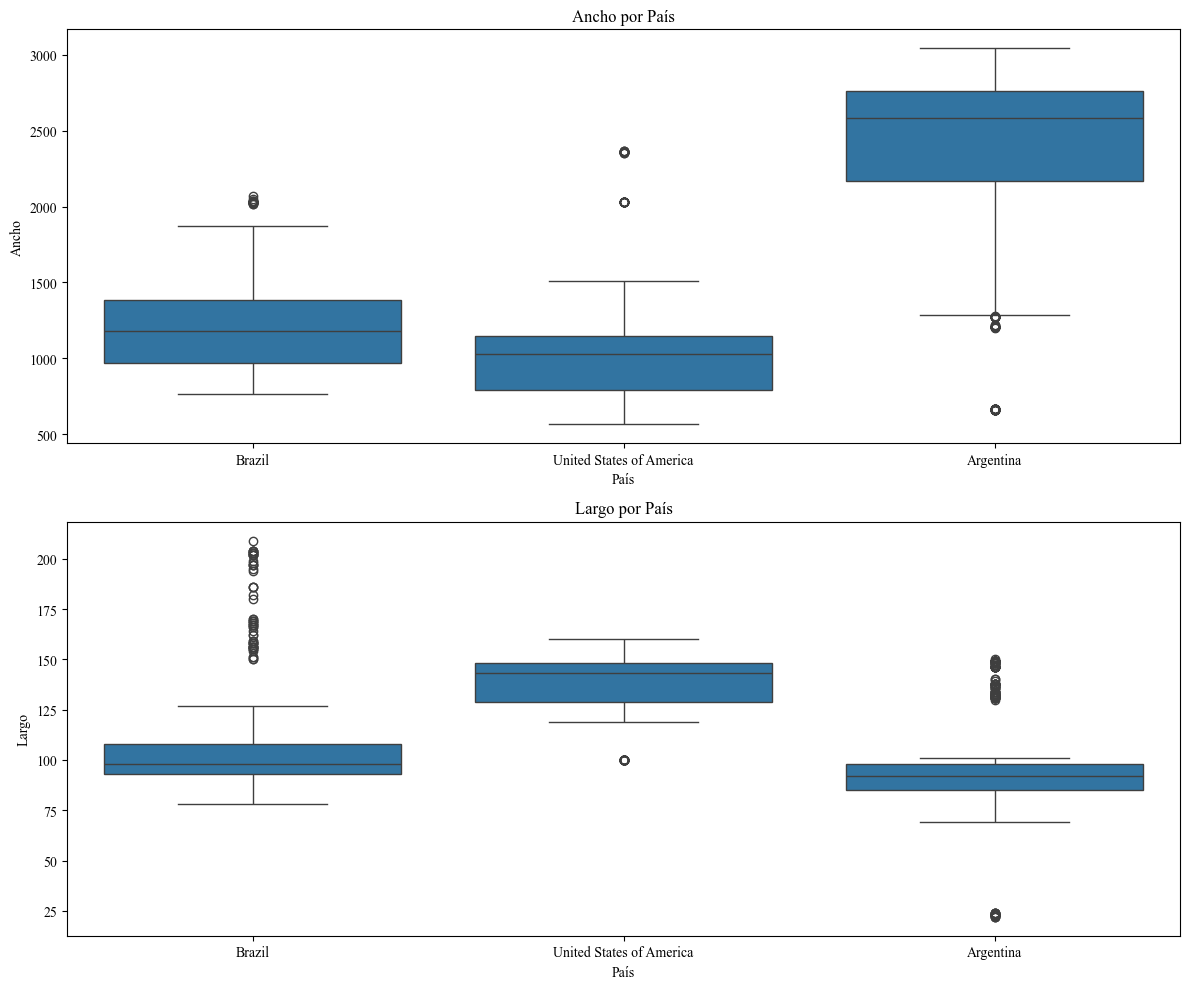

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Diagrama de caja y bigotes para el ancho por país
sns.boxplot(x='country', y='ancho', data=nuevo_df, ax=axes[0])
axes[0].set_title('Ancho por País')
axes[0].set_xlabel('País')
axes[0].set_ylabel('Ancho')

# Diagrama de caja y bigotes para el largo por país
sns.boxplot(x='country', y='largo', data=nuevo_df, ax=axes[1])
axes[1].set_title('Largo por País')
axes[1].set_xlabel('País')
axes[1].set_ylabel('Largo')

# Ajustar diseño
plt.tight_layout()

# Mostrar gráficos
plt.show()


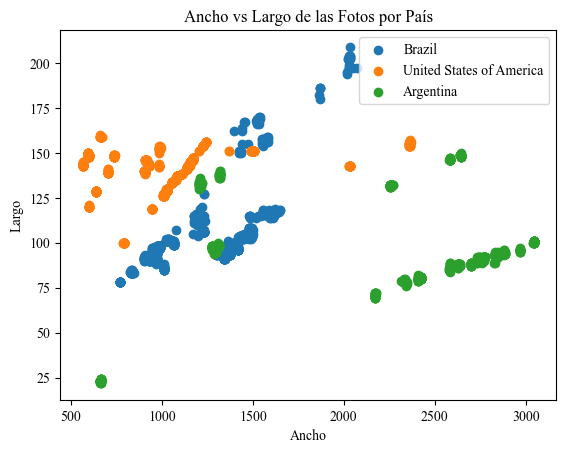

In [32]:
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots()

# Iterar sobre cada país único en el DataFrame
for country in nuevo_df['country'].unique():
    # Seleccionar las filas correspondientes al país actual
    df_country = nuevo_df[nuevo_df['country'] == country]
    
    # Graficar un scatter plot para el país actual
    ax.scatter(df_country['ancho'], df_country['largo'], label=country)

# Agregar etiquetas y título
ax.set_xlabel('Ancho')
ax.set_ylabel('Largo')
ax.set_title('Ancho vs Largo de las Fotos por País')
ax.legend()

# Mostrar el plot
plt.show()


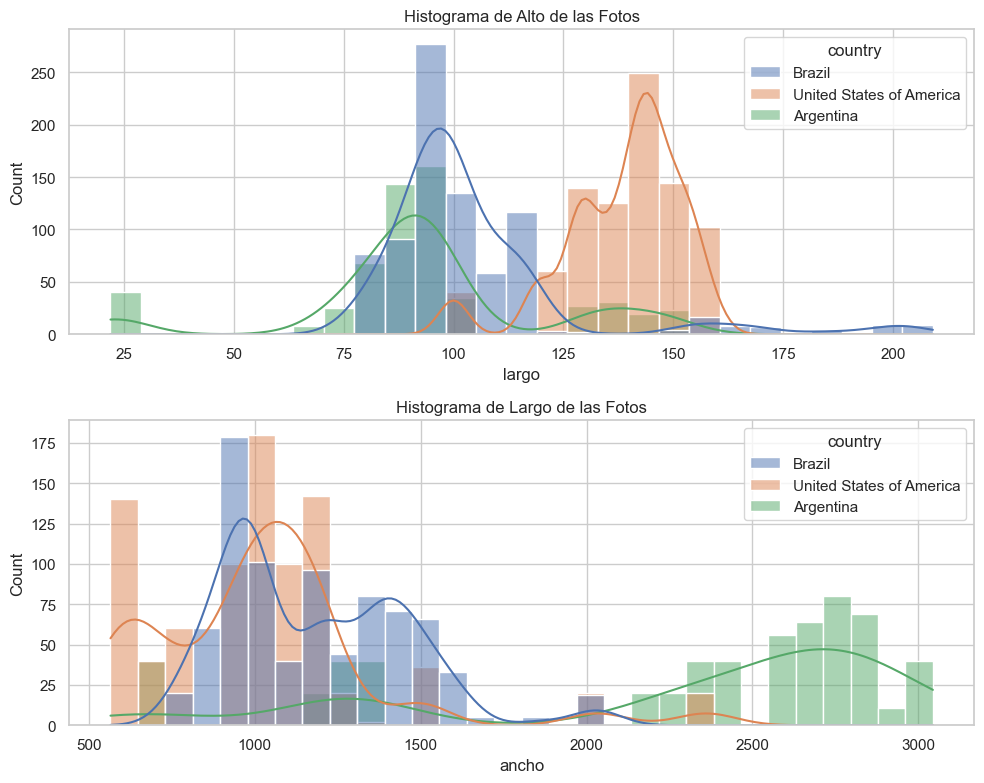

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid")

# Crear subtramas para alto y largo
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Histograma de alto de las fotos, coloreado por país
sns.histplot(data=nuevo_df, x='largo', hue='country', ax=axes[0], kde=True)
axes[0].set_title('Histograma de Alto de las Fotos')

# Histograma de largo de las fotos, coloreado por país
sns.histplot(data=nuevo_df, x='ancho', hue='country', ax=axes[1], kde=True)
axes[1].set_title('Histograma de Largo de las Fotos')

# Ajustar diseño
plt.tight_layout()

# Mostrar gráfico
plt.show()
